In [24]:
#IMPORTAZIONE LIBRERIE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve, confusion_matrix, classification_report

In [25]:
#IMPORTAZIONE DATASET

TRAIN_PATH = r"C:\Users\danie\Desktop\Python\Progetti\Titanic\train.csv"
TEST_PATH  = r"C:\Users\danie\Desktop\Python\Progetti\Titanic\test.csv"

dati_train = pd.read_csv(TRAIN_PATH)

dati_train.info()
print(dati_train.isna().sum()) #le variabili AGE, ENBARKED e CABIN presentano NA

#FEATURE ENGINEERING (PT.1)

#Creazione variabile: Famiglia
#Si aggregano le informazioni contenute nelle variabili SibSp e Parch per avere una variabile che mi indichi la dimensione del gruppo familiare
#Si rende la variabile categorica, ipotizzando che la variabile possa catturare differenze nella probabilità di sopravvivenza

dati_train["FamilySize"] = dati_train["SibSp"] + dati_train["Parch"]

print(dati_train["FamilySize"].value_counts())

def categorize_family(size):
    if size == 0:
        return "Solo"
    elif size <= 3:
        return "Piccolo gruppo"
    else:
        return "Grande gruppo"

dati_train["Family"] = dati_train["FamilySize"].apply(categorize_family)

print(dati_train["Family"].value_counts())

dati_train.drop(["SibSp", "Parch", "FamilySize", "Name"], axis = 1, inplace = True) #eliminazione colonne inutili

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Fam

In [26]:
#IMPUTAZIONE DATI MANCANTI

#per la variabile EMBARKED si hanno solo 2 NA, per cui si procede imputando la moda ai missing

print(dati_train["Embarked"].value_counts()) #non fa vedere che ci sono gli NA
#la moda è S

dati_train["Embarked"].fillna(dati_train["Embarked"].mode()[0], inplace = True)
#mode() restituisce una Series, quindi si prende [0] per il primo valore più frequente
print(dati_train["Embarked"].value_counts())

#oppure:
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(strategy="most_frequent")
#dati_train["Embarked"] = imp.fit_transform(dati_train[["Embarked"]])[:, 0]
#dati_train[["Embarked"]] → DataFrame 2D richiesto da SimpleImputer
#imp.fit_transform(...) → array 2D (n_samples, 1)
#[:, 0] → seleziona la prima (e unica) colonna come array 1D compatibile con pandas

#Variabile CABIN

dati_train["Cabin"].value_counts()
#la variabile cabin ha molte modalità, è eccessivamente sparsa
#Si procede con la sua eliminazione dal dataset
dati_train.drop("Cabin", axis = 1, inplace = True)
dati_train

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


C:\Users\danie\AppData\Local\Temp\ipykernel_15108\2322881836.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dati_train["Embarked"].fillna(dati_train["Embarked"].mode()[0], inplace = True)


,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Family
0,1,0,3,male,22.0,A/5 21171,7.2500,S,Piccolo gruppo
1,2,1,1,female,38.0,PC 17599,71.2833,C,Piccolo gruppo
2,3,1,3,female,26.0,STON/O2. 3101282,7.9250,S,Solo
3,4,1,1,female,35.0,113803,53.1000,S,Piccolo gruppo
4,5,0,3,male,35.0,373450,8.0500,S,Solo
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,211536,13.0000,S,Solo
887,888,1,1,female,19.0,112053,30.0000,S,Solo
888,889,0,3,female,NaN,W./C. 6607,23.4500,S,Piccolo gruppo
889,890,1,1,male,26.0,111369,30.0000,C,Solo


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


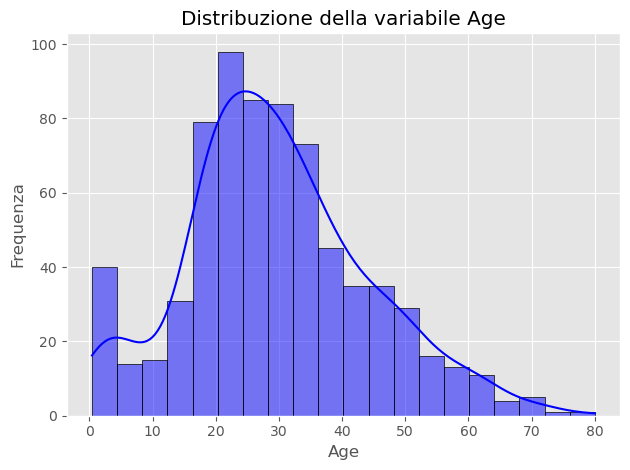

Age    Sex   
False  male      453
       female    261
True   male      124
       female     53
Name: count, dtype: int64


Sex
female    16.878981
male      21.490468
Name: Age, dtype: float64


Age    Pclass
False  3         355
       1         186
       2         173
True   3         136
       1          30
       2          11
Name: count, dtype: int64


Pclass
1    13.888889
2     5.978261
3    27.698574
Name: Age, dtype: float64


Age    Embarked
False  S           556
       C           130
       Q            28
True   S            90
       Q            49
       C            38
Name: count, dtype: int64


Embarked
C    22.619048
Q    63.636364
S    13.931889
Name: Age, dtype: float64




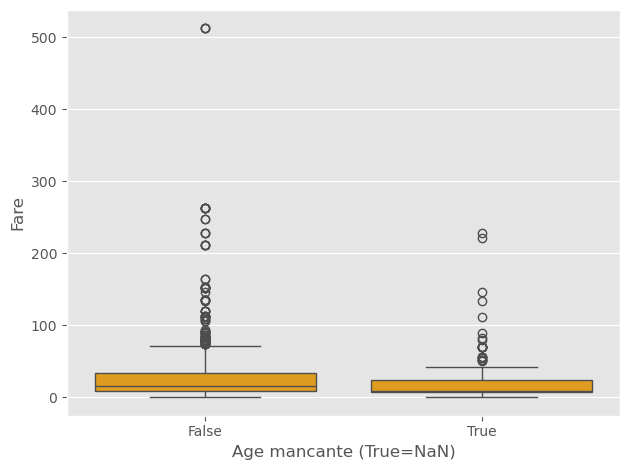

In [27]:
#Variabile AGE

print(dati_train["Age"].describe())

plt.style.use("ggplot")
sn.histplot(x = "Age", data = dati_train, color = "blue", edgecolor = "black", kde = True)
plt.title("Distribuzione della variabile Age")
plt.xlabel("Age")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()
#distribuzione asimmetrica positiva
#si potrebbe pensare di imputare i dati mancanti con la mediana
#la mediana ha una maggiore robustezza agli outlier
#occorre capire se i missing sono completly at random oppure se dipendono da qualche variabile(Missing at Random)

print(dati_train.groupby(dati_train["Age"].isna())["Sex"].value_counts()) #age mancante per sesso
freq_sex = dati_train.groupby('Sex')['Age'].apply(lambda x: x.isna().mean() * 100) #per avere le percentuali di missing
print("\n")
print(freq_sex)
print("\n")

print(dati_train.groupby(dati_train["Age"].isna())["Pclass"].value_counts()) #age mancante per pclass
freq_pclass = dati_train.groupby("Pclass")["Age"].apply(lambda x: x.isna().mean() * 100) #percentuali dei missing
print("\n")
print(freq_pclass)
print("\n")

print(dati_train.groupby(dati_train["Age"].isna())["Embarked"].value_counts()) #age mancante per embarked
freq_emb = dati_train.groupby("Embarked")["Age"].apply(lambda x: x.isna().mean() * 100)
print("\n")
print(freq_emb)
print("\n")
#i missing di Age sembrano essere influenzati dalle variabili Sex, Pclass e Embarked, infatti:
#tra i maschi mancano 124 valori su 577 (21%), tra le femmine il 17% (53 su 314)
#i missing sono presenti maggiormente nella modalità 3 della variabile pclass
#embarked potrebbe essere importante nell'imputazione dei missing di Age

sn.boxplot(x=dati_train["Age"].isna(), y=dati_train["Fare"], color = "orange")
plt.xlabel("Age mancante (True=NaN)")
plt.ylabel("Fare")
plt.tight_layout()
plt.show()
#non sembra esserci differenza tra i valori medi di FARE quando age è missing e quando non lo è

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family',
       'Pclass_enc_2', 'Pclass_enc_3', 'Family_enc_Piccolo gruppo',
       'Family_enc_Solo', 'Embarked_enc_Q', 'Embarked_enc_S', 'Sex_enc_male'],
      dtype='object')


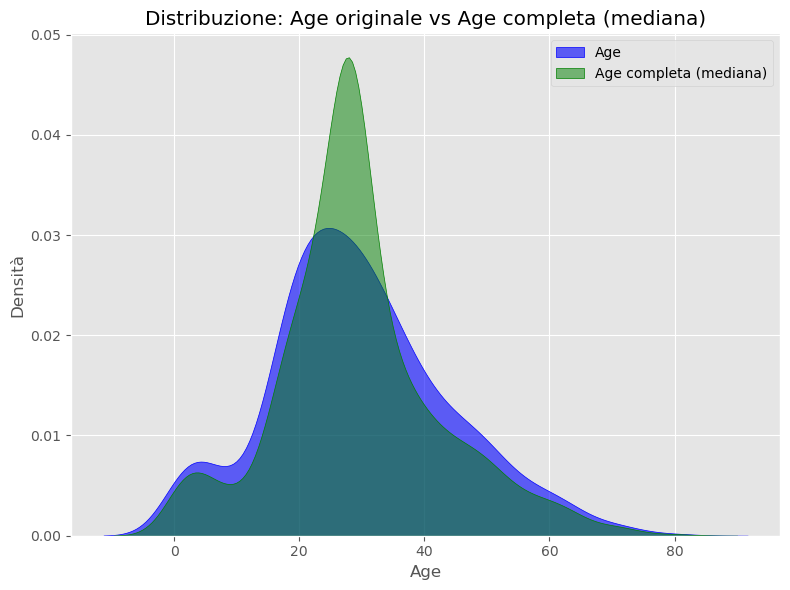

In [28]:
#Encoding variabili categoriali

def one_hot_encode(df, col, drop="first"):
    col_enc = f"{col}_enc"
    df[col_enc] = df[col].astype(str)
    
    ohe = OneHotEncoder(drop=drop, sparse_output=False, dtype=int) #crea il l'encoder OneHot
    encoded = ohe.fit_transform(df[[col_enc]]) #applica l'encoder
    
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([col_enc]), index=df.index)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

dati_train = one_hot_encode(dati_train, "Pclass")
dati_train = one_hot_encode(dati_train, "Family")
dati_train = one_hot_encode(dati_train, "Embarked")
dati_train = one_hot_encode(dati_train, "Sex", drop="if_binary")

dati_train.drop(["PassengerId", "Ticket", "Pclass_enc", "Family_enc", "Embarked_enc", "Sex_enc",], axis = 1, inplace = True) #eliminazione colonne inutili

print(dati_train.columns)

df_impute = dati_train[["Age", "Sex_enc_male", "Pclass_enc_2", "Pclass_enc_3", "Embarked_enc_Q", "Embarked_enc_S", "Fare", "Family_enc_Piccolo gruppo", "Family_enc_Solo"]].copy()
mask_na = df_impute["Age"].isna()

#IMPUTAZIONE MISSING VALUES AGE

#Imputazione dei valori mancanti con la mediana

df_mediana = dati_train.copy()
df_mediana["Age_imputata"] = df_mediana["Age"].fillna(df_mediana["Age"].median())

val_osservati = df_mediana.loc[~df_mediana["Age"].isna(), "Age"] #prende i valori osservati, i valori in cui Age non è NA
val_imputati = df_mediana.loc[mask_na, "Age_imputata"] #prende i valori di Age completa, sostituisce agli NA il valore imputato (mediana)

#Grafico: Age vs Age completa (mediana)

plt.figure(figsize=(8,6))
plt.style.use("ggplot")

sn.kdeplot(df_mediana["Age"], label="Age", fill=True, alpha=0.6, color="blue")
sn.kdeplot(df_mediana["Age_imputata"], label="Age completa (mediana)", fill=True, alpha=0.5, color="green")
plt.title("Distribuzione: Age originale vs Age completa (mediana)")
plt.xlabel("Age")
plt.ylabel("Densità")
plt.legend()
plt.tight_layout()
plt.show()
#le distribuzioni sono simili nelle code
#la distribuzione di Age imputata con la mediana mostra un picco molto pronunciato attorno ai 30 anni 

In [29]:
#Divisione Train set e validation set

#Questa divisione è necessaria:
#La divisione del dataset in train e validation set prima di applicare l’imputazione MICE è fondamentale per evitare il data leakage, 
#cioè l’utilizzo involontario di informazioni provenienti dai dati di validazione durante la fase di addestramento. 
#Se l’imputazione venisse eseguita sull’intero dataset prima della divisione, l’algoritmo MICE stimerebbe i valori mancanti di Age sfruttando 
#anche le relazioni presenti nel validation set, fornendo così al modello informazioni che in realtà non dovrebbe conoscere. 
#Separando prima i dati, invece, l’imputer viene addestrato solo sul training set e successivamente applicato al validation set, garantendo che 
#quest’ultimo rimanga completamente “nuovo” agli occhi del modello e che le prestazioni ottenute siano una stima realistica della sua capacità predittiva.

df_impute = dati_train[["Age", "Sex_enc_male", "Pclass_enc_2", "Pclass_enc_3","Embarked_enc_Q", "Embarked_enc_S", "Fare","Family_enc_Piccolo gruppo", "Family_enc_Solo"]].copy()
mask_na = df_impute["Age"].isna()

y = dati_train['Survived']
X = dati_train.drop(columns='Survived')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Split eseguito: X_train shape", X_train.shape, "X_val shape", X_val.shape)

Split eseguito: X_train shape (712, 13) X_val shape (179, 13)


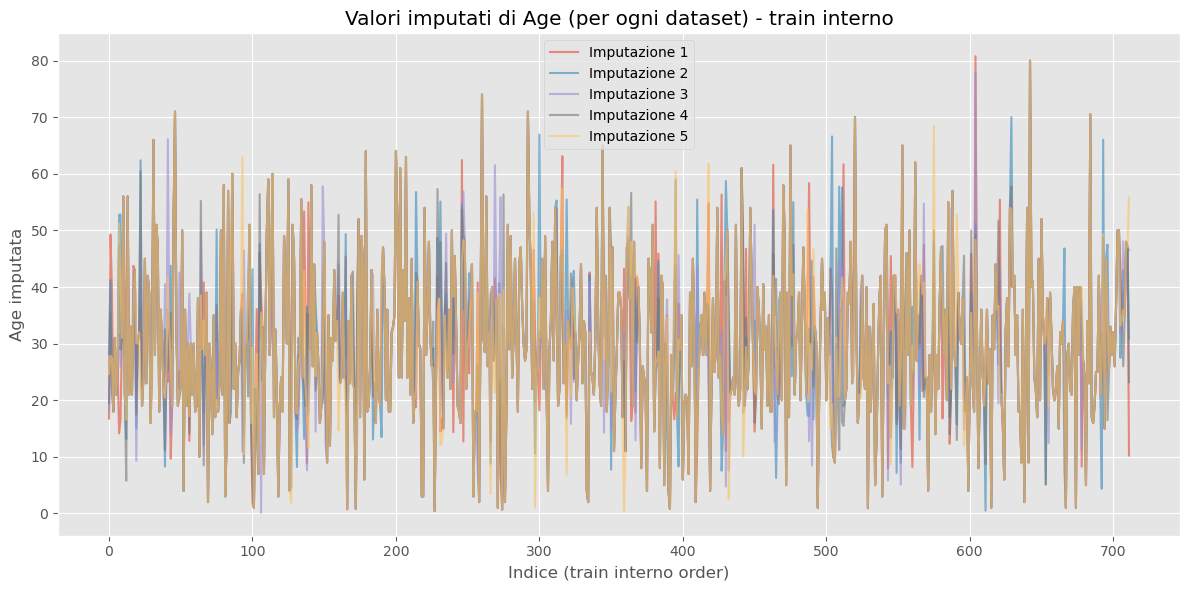

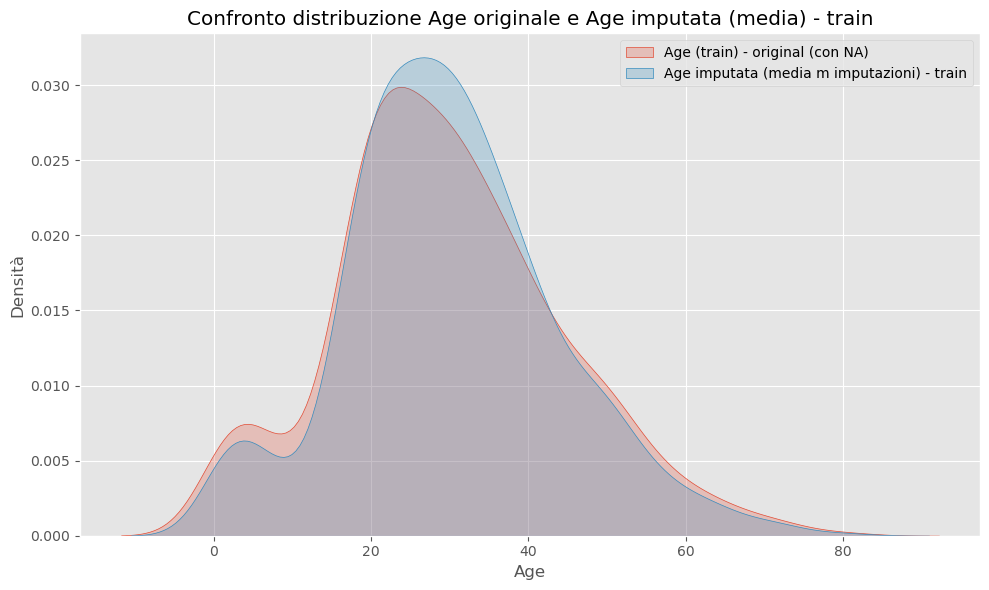


Descrittive Age (imputate - train):
count    712.000000
mean      30.160819
std       14.503784
min        0.420000
25%       20.572912
50%       29.000000
75%       39.029289
max       80.797541
Name: Age, dtype: float64

Descrittive Age (originale - train, con NA):
count    575.000000
mean      29.807687
std       14.485211
min        0.420000
25%       21.000000
50%       28.500000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

Verifica NA residui:
train NA: 0
val   NA: 0


In [30]:
#IMPUTAZIONE MICE  (fit solo sul train)

vars_for_impute = df_impute.columns.tolist()

df_train_imp = X_train[vars_for_impute].copy()
df_val_imp   = X_val[vars_for_impute].copy()

m = 5  #numero di dataset imputati
random_seeds = [33, 59, 96, 9, 77]  #semi scelti 
imputed_dfs = []  #lista vuota che conterrà i dataset imputati 

for i, seed in enumerate(random_seeds):
    imputer = IterativeImputer(
        max_iter=10,
        sample_posterior=True,  #rende l’imputazione stocastica
        random_state=seed,      #usa un seme diverso a ogni ciclo
        initial_strategy="mean",
        min_value=0             #età minima possibile
    )
    imputer.fit(df_train_imp)
    df_temp = pd.DataFrame(imputer.transform(df_train_imp), columns=df_train_imp.columns, index=df_train_imp.index)
    imputed_dfs.append(df_temp)  #inserisce il dataset imputato nella lista

#Grafico dei valori imputati

plt.figure(figsize=(12,6))
plt.style.use("ggplot")

for i, df_temp in enumerate(imputed_dfs): #enumerate serve per iterare su una sequenza ottenendo l'indice e il valore di ogni elemento
    plt.plot(df_temp["Age"].values, label=f"Imputazione {i+1}", alpha=0.6)

plt.title("Valori imputati di Age (per ogni dataset) - train interno")
plt.xlabel("Indice (train interno order)")
plt.ylabel("Age imputata")
plt.legend()
plt.tight_layout()
plt.show()

#Colonna finale Age imputata (media tra dataset) per il train

df_concat = pd.concat([df_temp["Age"] for df_temp in imputed_dfs], axis=1)
df_concat.columns = [f"imp_{i+1}" for i in range(len(imputed_dfs))]
age_mean_imputed_train = df_concat.mean(axis=1)

#Aggiunge Age_imputata temporanea a X_train per i grafici

X_train_with_imputed = X_train.copy()
X_train_with_imputed.loc[age_mean_imputed_train.index, "Age_imputata"] = age_mean_imputed_train.values

# Grafico confronto distribuzioni Age originale vs Age imputata 

plt.figure(figsize=(10,6))
sn.kdeplot(X_train_with_imputed["Age"].dropna(), label="Age (train) - original (con NA)", fill=True)
sn.kdeplot(X_train_with_imputed["Age_imputata"].dropna(), label="Age imputata (media m imputazioni) - train", fill=True)
plt.title("Confronto distribuzione Age originale e Age imputata (media) - train")
plt.xlabel("Age")
plt.ylabel("Densità")
plt.legend()
plt.tight_layout()
plt.show()

#ora si prepara l'imputer "definitivo" fit su df_train_imp e si traformano train e validation
 
imputer_final = IterativeImputer(max_iter=10, sample_posterior=True, random_state=33, initial_strategy="mean", min_value=0)
imputer_final.fit(df_train_imp)  #FIT solo sul train

train_imp_final = pd.DataFrame(imputer_final.transform(df_train_imp), columns=df_train_imp.columns, index=df_train_imp.index)
val_imp_final   = pd.DataFrame(imputer_final.transform(df_val_imp), columns=df_val_imp.columns, index=df_val_imp.index)

#sostituisce Age imputata in X_train e X_val

X_train.loc[:, "Age"] = np.round(train_imp_final["Age"], 0).astype(int)
X_val.loc[:, "Age"]   = np.round(val_imp_final["Age"], 0).astype(int)

#rimozione di eventuali colonne temporanee

if "Age_imputata" in X_train_with_imputed.columns:
    X_train_with_imputed.drop(columns=["Age_imputata"], inplace=True, errors="ignore")

print("\nDescrittive Age (imputate - train):")
print(train_imp_final["Age"].describe())

print("\nDescrittive Age (originale - train, con NA):")
print(df_train_imp["Age"].describe())

print("\nVerifica NA residui:")
print("train NA:", X_train["Age"].isna().sum())
print("val   NA:", X_val["Age"].isna().sum())

#Ricostruisce dati_train aggiornato 

train_combined = pd.concat([X_train, X_val], axis=0).sort_index()
y_combined = pd.concat([y_train, y_val], axis=0).sort_index()
dati_train = train_combined.copy()
dati_train["Survived"] = y_combined

Survived
0    549
1    342
Name: count, dtype: int64
38.38383838383838

=== Sex ===
Sex
male      577
female    314
Name: count, dtype: int64
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815

=== Embarked ===
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64
Survived          0          1
Embarked                      
C         44.642857  55.357143
Q         61.038961  38.961039
S         66.099071  33.900929

=== Family ===
Family
Solo              537
Piccolo gruppo    292
Grande gruppo      62
Name: count, dtype: int64
Survived                0          1
Family                              
Grande gruppo   83.870968  16.129032
Piccolo gruppo  42.123288  57.876712
Solo            69.646182  30.353818

=== Pclass ===
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Survived          0          1
Pclass                        
1         37.037037  62.962963
2         52.717391  47.282609

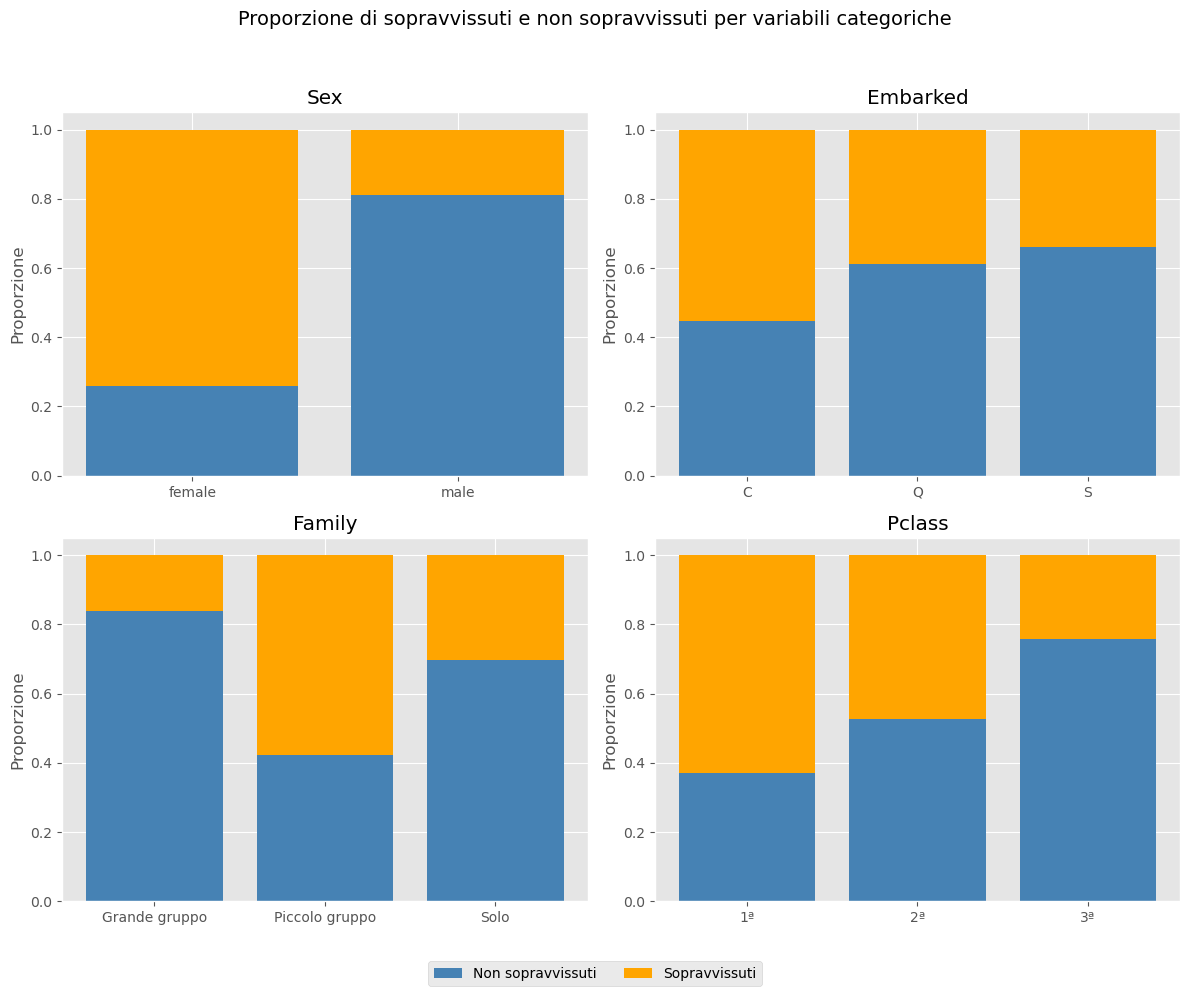

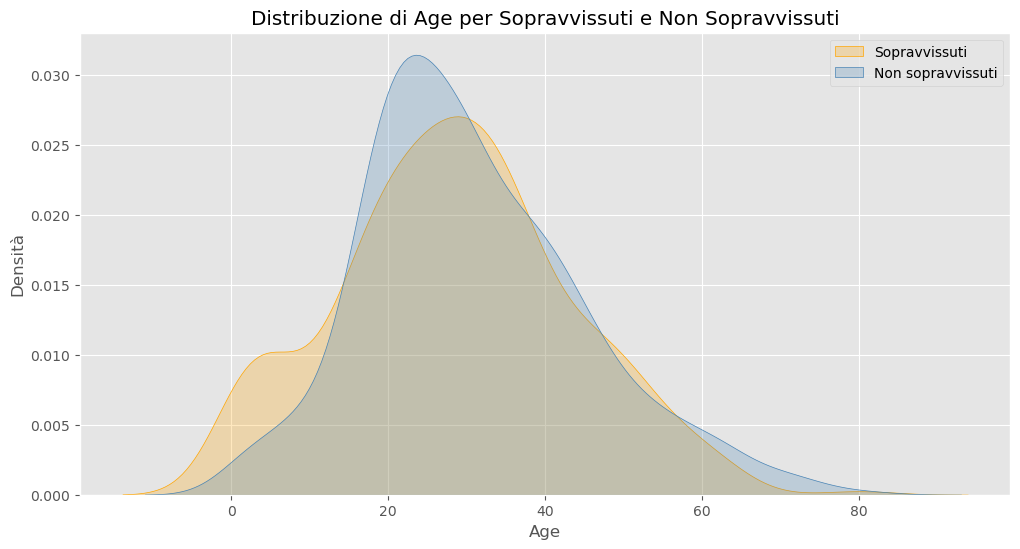

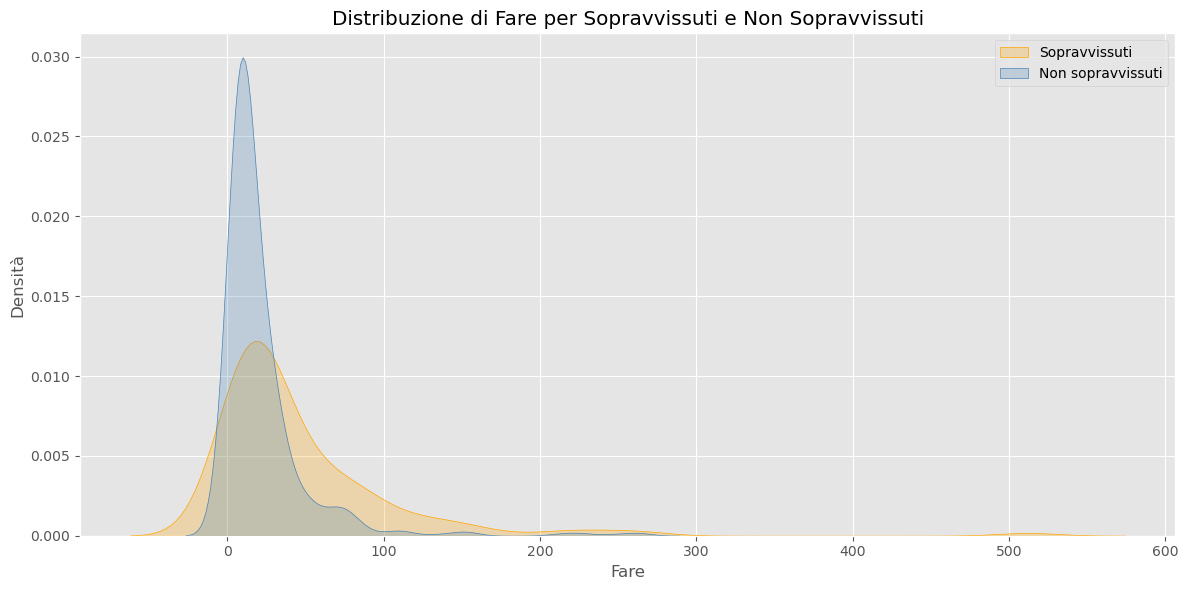

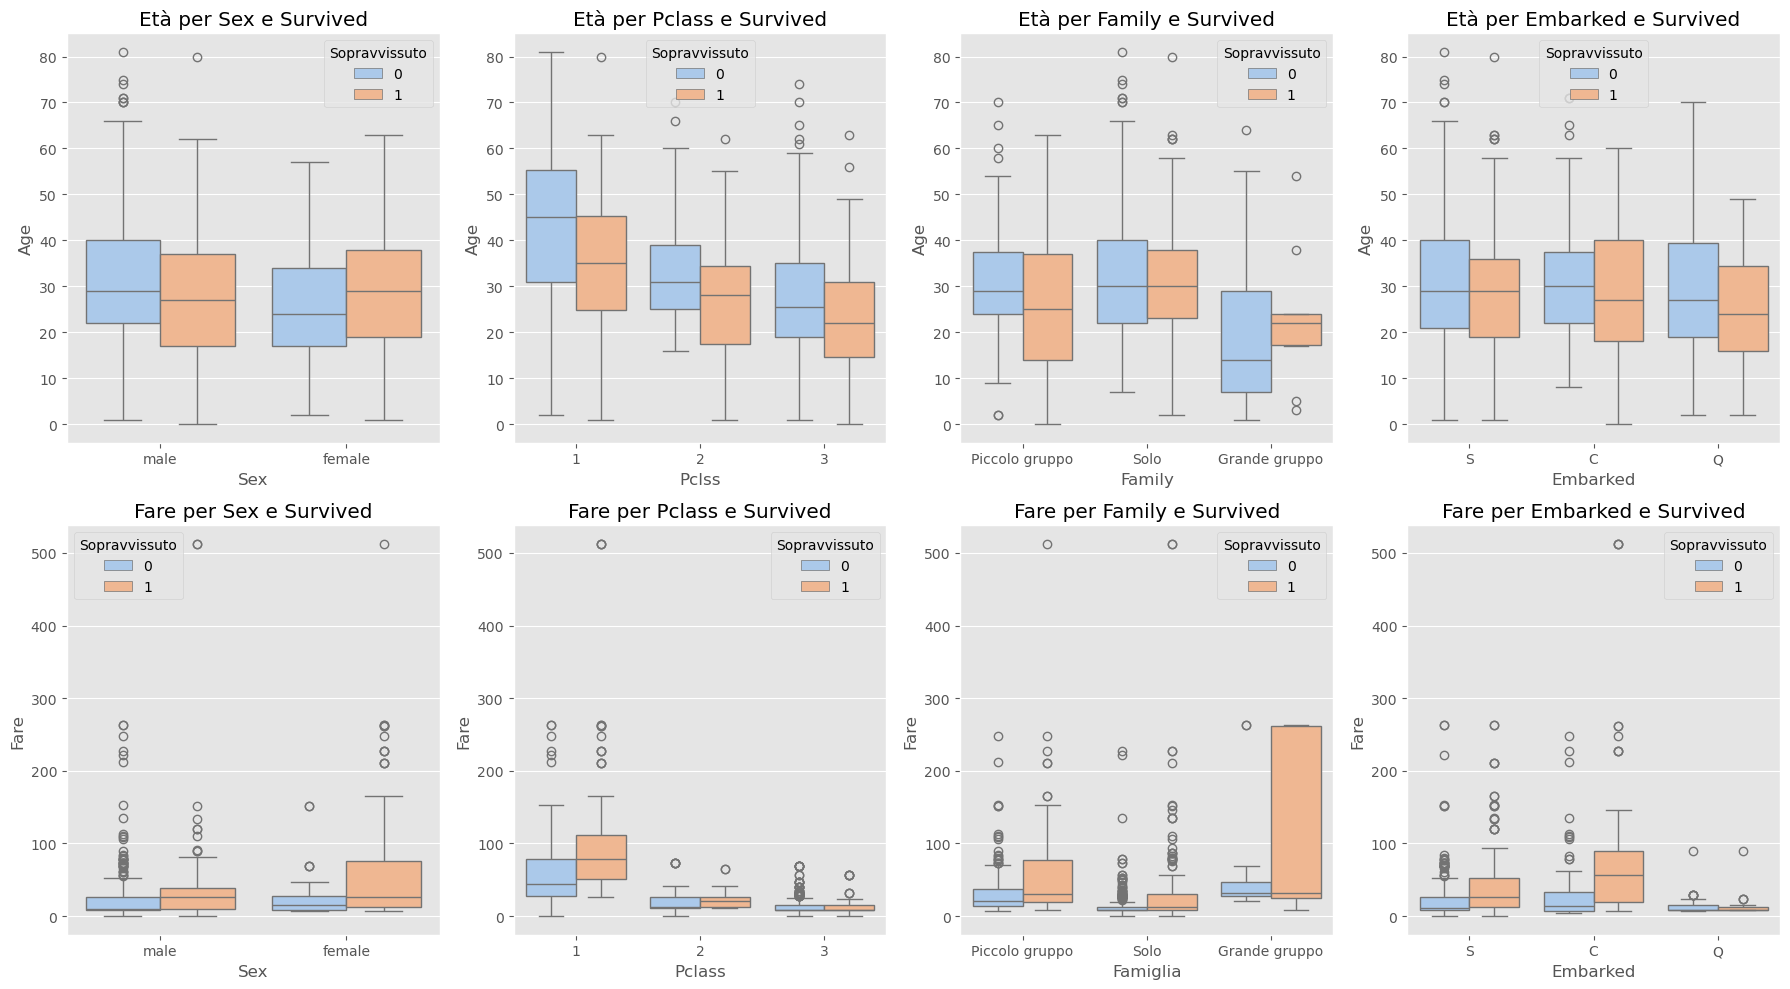

In [31]:
#ANALISI ESPLORATIVA

dati_train["Survived"].value_counts() #0: 549 / 1: 342
print(dati_train["Survived"].value_counts())
print(dati_train["Survived"].mean() * 100) #il 38,4% è sopravvissuto

#Variabili categoriali

plt.style.use("ggplot")
vars_cat = ["Sex", "Embarked", "Family", "Pclass"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  #2 righe x 2 colonne
axes = axes.flatten()  #trasforma in lista per iterare più facilmente

for i, var in enumerate(vars_cat):
    ax = axes[i]
    #Tabella e proporzioni
    print(f"\n=== {var} ===")
    print(dati_train[var].value_counts())
    print(pd.crosstab(dati_train[var], dati_train["Survived"], normalize="index") * 100)
    
    prop = dati_train.groupby(var)["Survived"].value_counts(normalize=True).unstack()

    x = range(len(prop.index)) #serve come posizione delle basse sull'asse x
    ax.bar(x, prop[0].values, label="Non sopravvissuti", color="steelblue") #plotta la serie di barre corrispondente ai non sopravvissuti
    ax.bar(x, prop[1].values, bottom=prop[0].values, label="Sopravvissuti", color="orange") #plotta la seconda serie di barre corrispondente ai sopravvissuti
    #bottom=prop[0].values fa sì che queste barre partano sopra le barre precedenti (impilate)

    if var == "Pclass":
        labels = ["1ª", "2ª", "3ª"] #etichette asse x
    else:
        labels = [str(l) for l in prop.index]
    ax.set_xticks(x) #specifica dove posizionare le etichette sull'asse delle ascisse
    ax.set_xticklabels(labels) #assegna il nome a ciascuna posizione x sull'asse delle ascisse
    ax.set_title(f"{var}")
    ax.set_ylabel("Proporzione")

#legenda unica per tutta la figura
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2)
fig.suptitle("Proporzione di sopravvissuti e non sopravvissuti per variabili categoriche", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # lascia spazio alla legenda e al titolo
plt.show()

#Variabili numeriche

vars_num = ["Age", "Fare"]

colors = {0: "steelblue", 1: "orange"}  #colori: 0 = non sopravvissuti, 1 = sopravvissuti

for var in vars_num:
    plt.figure(figsize=(12, 6))
    
    sn.kdeplot(data=dati_train[dati_train.Survived == 1],x=var,color=colors[1],fill=True) #KDE per sopravvissuti
    sn.kdeplot(data=dati_train[dati_train.Survived == 0],x=var,color=colors[0],fill=True) #KDE per non sopravvissuti
    
    plt.title(f'Distribuzione di {var} per Sopravvissuti e Non Sopravvissuti')
    plt.xlabel(var)
    plt.ylabel('Densità')
    plt.legend(['Sopravvissuti', 'Non sopravvissuti'])

plt.tight_layout()
plt.show()

def plot_survival_boxplots_subplot(data, plots_info, nrows=0, ncols=0, figsize=(18,10)):
    """
    Crea tutti i boxplot in un'unica figura con subplot, hue=Survived.
    Parametri:
    - data: DataFrame con i dati
    - plots_info: lista di dizionari con chiavi:
        - 'x': variabile categoriale sull'asse x
        - 'y': variabile numerica sull'asse y
        - 'title': titolo del grafico
        - 'xlabel': label asse x
        - 'ylabel': label asse y
    - nrows: numero di righe della griglia
    - ncols: numero di colonne della griglia
    - figsize: dimensione complessiva della figura
    """
    plt.style.use("ggplot")
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # per iterare facilmente
    
    for ax, info in zip(axes, plots_info):
        sn.boxplot(data=data,x=info['x'],y=info['y'],hue="Survived",palette="pastel",ax=ax)
        ax.set_title(info['title'])
        ax.set_xlabel(info.get('xlabel', info['x']))
        ax.set_ylabel(info.get('ylabel', info['y']))
        ax.legend(title="Sopravvissuto")        
    plt.tight_layout()
    plt.show()

#lista dei grafici
plots = [
    {'x': 'Sex', 'y': 'Age', 'title': "Età per Sex e Survived", 'xlabel': 'Sex', 'ylabel': 'Age'},
    {'x': 'Pclass', 'y': 'Age', 'title': "Età per Pclass e Survived", 'xlabel': 'Pclss', 'ylabel': 'Age'},
    {'x': 'Family', 'y': 'Age', 'title': "Età per Family e Survived", 'xlabel': 'Family', 'ylabel': 'Age'},
    {'x': 'Embarked', 'y': 'Age', 'title': "Età per Embarked e Survived", 'xlabel': 'Embarked', 'ylabel': 'Age'},

    {'x': 'Sex', 'y': 'Fare', 'title': "Fare per Sex e Survived", 'xlabel': 'Sex', 'ylabel': 'Fare'},
    {'x': 'Pclass', 'y': 'Fare', 'title': "Fare per Pclass e Survived", 'xlabel': 'Pclass', 'ylabel': 'Fare'},
    {'x': 'Family', 'y': 'Fare', 'title': "Fare per Family e Survived", 'xlabel': 'Famiglia', 'ylabel': 'Fare'},
    {'x': 'Embarked', 'y': 'Fare', 'title': "Fare per Embarked e Survived", 'xlabel': 'Embarked', 'ylabel': 'Fare'}
]

plot_survival_boxplots_subplot(dati_train, plots, nrows=2, ncols=4, figsize=(18,10)) #genera tutti i boxplot in subplot 2x4

#Nei grafici a barre impilate emerge chiaramente che il sesso e la classe di viaggio sono i fattori più determinanti: 
#la proporzione di sopravvissuti tra le donne è nettamente superiore rispetto agli uomini
#mentre i passeggeri della prima classe presentano le più alte probabilità di sopravvivenza, con un netto svantaggio per la terza. 
#Anche il porto d’imbarco risulta associato alla sopravvivenza: chi si è imbarcato a C mostra tassi di sopravvivenza più elevati rispetto agli altri porti,
#La dimensione del gruppo familiare, inoltre, rivela un effetto non lineare: i piccoli gruppi familiari sembrano aver avuto maggiori probabilità di sopravvivere,
#mentre viaggiare da soli o in gruppi molto grandi riduceva le possibilità di salvezza.
#I boxplot che mettono in relazione l’età e la tariffa (Fare) con la sopravvivenza confermano e approfondiscono queste tendenze. 
#I sopravvissuti risultano mediamente più giovani, soprattutto tra le donne e nelle classi superiori, 
#suggerendo che l’età abbia giocato un ruolo importante nelle priorità di salvataggio.  
#Le tariffe più elevate sono associate a una maggiore probabilità di sopravvivenza

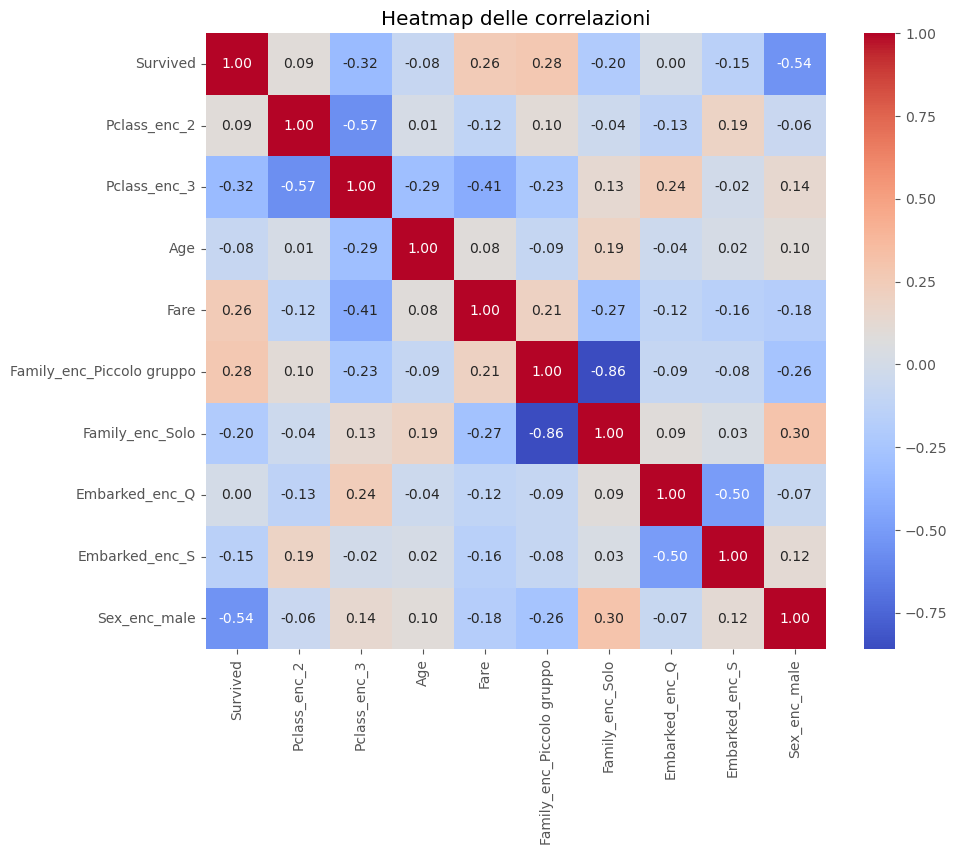

In [32]:
#Correlazione lineare 

cols = ["Survived", "Pclass_enc_2", "Pclass_enc_3", "Age", "Fare", "Family_enc_Piccolo gruppo","Family_enc_Solo", "Embarked_enc_Q", "Embarked_enc_S", "Sex_enc_male"]

plt.figure(figsize=(10,8))
sn.heatmap(dati_train[cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap delle correlazioni")
plt.show()

#La matrice di correlazione mostra come il target(Survived) e le variabili indipendenti sono linearmente associate tra loro:

#Predittori principali:
#Tra le variabili considerate, Sex, Pclass e Fare mostrano correlzioni più forti con la variabile target
#(meno prob di sopravvivenza per gli uomini, vale il contrario per i passeggeri di classe superiore e con biglietti più costosi)
#anche la dimensione dela famiglia ha un effetto moderato sul target

#Effetti delle variabili codificate:
#Le colonne che derivano dal one-hot encoding (Family, Embarked) mostrano correlazioni elevate, ma questo è un fenomeno atteso.
#Fenomeno atteso perché dovuto alla ridondanza dell'one-hot encoding (ogni persona appartiene ad una sola categoria),
#quindi le colonne sono linearmente dipendenti. Queste correlazioni NON RAPPRESENTANO RELAZIONI REALI TRA VARIABILI

#Variabili con effetto trascurabile:
#La variabile Age è quella che mostra la correlazione più bassa con il target, non apporta informazioni lineari sulla sopravvivenza

In [34]:
#FEATURE SELECTION

dati_train.drop(["Pclass", "Sex", "Embarked", "Family"], axis = 1, inplace = True, errors="ignore") #rimozione colonne inutili

y_train_full = dati_train['Survived']
X_train_full = dati_train.drop(columns='Survived')

#Standardizzazione delle feature numeriche

num_cols = ["Age", "Fare"] #prende le colonne numeriche

scaler_full = StandardScaler()
X_scaled_full = X_train_full.copy()
X_scaled_full[num_cols] = scaler_full.fit_transform(X_train_full[num_cols]) #standarizza le variabili numeriche (hanno scale diverse)

lasso = LogisticRegressionCV(penalty='l1', solver='saga', cv = 10, scoring = 'roc_auc', max_iter = 5000, refit = True, class_weight = "balanced")
lasso.fit(X_scaled_full, y_train_full)

coefs = pd.Series(lasso.coef_[0], index=X_scaled_full.columns)
selected_features = coefs[coefs != 0].index.tolist()

print(f"Media AUC sui 10 fold: {lasso.scores_[1].mean():.3f}")
print(selected_features)
#La regressione logistica con penalizzazione LASSO può essere utilizzata come strumento di feature selection, 
#grazie alla sua capacità di annullare alcuni coefficienti delle variabili meno rilevanti. 
#Applicando la LASSO alle variabili di interesse, si è osservato che nessuna feature è stata eliminata: 
#tutte le colonne presenti in X_train hanno coefficienti diversi da zero.  
#Quindi tutte le variabili considerate apportano un contributo significativo alla previsione della sopravvivenza dei passeggeri.

Media AUC sui 10 fold: 0.752
['Age', 'Fare', 'Pclass_enc_2', 'Pclass_enc_3', 'Family_enc_Piccolo gruppo', 'Family_enc_Solo', 'Embarked_enc_Q', 'Embarked_enc_S', 'Sex_enc_male']



--- 10-FOLD CROSS-VALIDATION ---
ACCURACY: 0.81 ± 0.04
PRECISION: 0.75 ± 0.07
RECALL  : 0.78 ± 0.03
F1      : 0.76 ± 0.04
ROC_AUC : 0.86 ± 0.03

--- VALUTAZIONE SUL VALIDATION SET ---
Accuracy : 0.79
Precision: 0.72
Recall   : 0.75
F1-score : 0.74
ROC AUC  : 0.85

Classification report (validation):
              precision    recall  f1-score   support

           0     0.8411    0.8182    0.8295       110
           1     0.7222    0.7536    0.7376        69

    accuracy                         0.7933       179
   macro avg     0.7817    0.7859    0.7835       179
weighted avg     0.7953    0.7933    0.7941       179



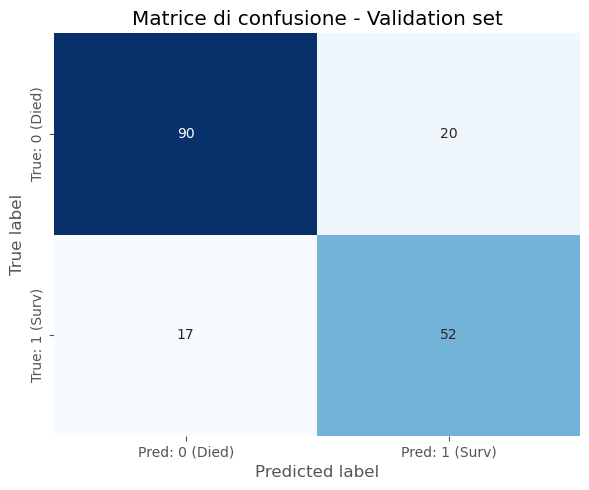

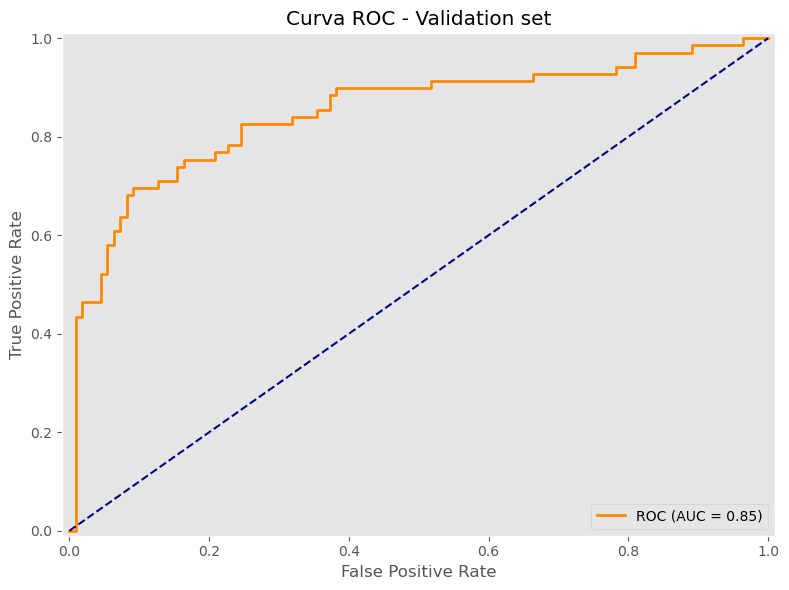

In [ ]:
# MODELLO LOGISTICO FINALE + 10-FOLD CROSS-VALIDATION

#Preparazione dati

X_tr_sel = X_train[selected_features].copy() #prende solo le feature selezionate dalla LASSO
X_val_sel = X_val[selected_features].copy()

#Scaling: standardizzo le colonne numeriche 

num_cols = ["Age", "Fare"] 
num_sel = [c for c in num_cols if c in selected_features] #tiene solo quelle numeriche effettivamente scelte dalla LASSO.

scaler_cv = StandardScaler()
scaler_cv.fit(X_tr_sel[num_sel])
X_tr_sel[num_sel] = scaler_cv.transform(X_tr_sel[num_sel])
X_val_sel[num_sel] = scaler_cv.transform(X_val_sel[num_sel])

#Cross-validation 10-fold 

lr_cv = LogisticRegression(solver='saga', max_iter=5000, class_weight="balanced")

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_results = cross_validate(lr_cv, X_tr_sel, y_train, cv=cv, scoring=scoring, return_train_score=False)

print("\n--- 10-FOLD CROSS-VALIDATION ---")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.upper():8s}: {scores.mean():.2f} ± {scores.std():.2f}")

# Addestramento del modello finale sul training (tutti i dati di X_train)

clr_final = LogisticRegression(solver='saga', max_iter=5000, class_weight="balanced")
clr_final.fit(X_tr_sel, y_train)

# Valutazione sul validation set

y_val_pred = clr_final.predict(X_val_sel)
y_val_proba = clr_final.predict_proba(X_val_sel)[:, 1]

acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred)
rec_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)
rocauc_val = roc_auc_score(y_val, y_val_proba)

print("\n--- VALUTAZIONE SUL VALIDATION SET ---")
print(f"Accuracy : {acc_val:.2f}")
print(f"Precision: {prec_val:.2f}")
print(f"Recall   : {rec_val:.2f}")
print(f"F1-score : {f1_val:.2f}")
print(f"ROC AUC  : {rocauc_val:.2f}")

#Classification report

print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred, digits=4))
#classification_report:
#confronta i valori veri (y_val) con le predizioni del modello (y_val_pred)
#calcola e mostra una tabella con le metriche principali di classificazione

#Matrice di confusione

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["Pred: 0 (Died)", "Pred: 1 (Surv)"],yticklabels=["True: 0 (Died)", "True: 1 (Surv)"])
plt.title("Matrice di confusione - Validation set")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

#Curva ROC sul validation set 

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {rocauc_val:.2f})', color='darkorange')
plt.plot([0,1], [0,1], linestyle='--', color='navy')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Validation set')
plt.legend(loc='lower right')
plt.grid(False)
plt.tight_layout()
plt.show()

#I risultati ottenuti dal modello mostrano complessivamente una buona performance sia durante la fase di cross-validation che sul validation set. 
#La 10-fold cross-validation evidenzia un’accuratezza media dell’81%, con una variabilità del 4%, suggerendo che il modello è stabile e generalizza bene sui dati non visti. 
#Anche gli altri indicatori di performance confermano questa tendenza: la precision media è pari al 75%, il recall al 78% e l’F1-score al 76%, 
#valori che indicano un buon equilibrio tra capacità del modello di identificare correttamente i casi positivi e di evitare falsi positivi. 
#Il ROC AUC, pari a 0.86, sottolinea una capacità discriminante elevata, confermando che il modello riesce a distinguere in modo efficace tra le due classi.

#La valutazione sul validation set mostra risultati leggermente inferiori, ma comunque coerenti con la cross-validation. 
#L’accuratezza si attesta al 79%, la precision al 72%, il recall al 75% e l’F1-score al 74%, mentre il ROC AUC rimane elevato a 0.85. 
#L’analisi più dettagliata per classe evidenzia come la classe 0 (morti) sia predetta con maggiore precisione e recall rispetto alla classe 1 (sopravvissuti),
#la quale mostra valori leggermente più bassi, indicando la presenza di un numero maggiore di falsi positivi e falsi negativi.

#La matrice di confusione conferma questi risultati: su 110 casi negativi, 90 sono correttamente classificati e 20 sono stati erroneamente predetti 
#come positivi; su 69 casi positivi, 52 sono correttamente identificati, mentre 17 risultano falsi negativi. 
#Questi valori evidenziano che il modello tende a predire correttamente la maggior parte dei casi, mantenendo un buon bilanciamento tra le due classi, 
#ma con una leggera difficoltà nel distinguere i positivi, che potrebbe essere migliorata eventualmente tramite 
#aggiustamento della soglia decisionale o strategie di bilanciamento delle classi.

In [ ]:
#PREVISIONE SUL TEST SET

dati_test = pd.read_csv(TEST_PATH)

dati_test.info()
print(dati_test.isna().sum())

#FEATURE ENGINEERING

dati_test["FamilySize"] = dati_test["SibSp"] + dati_test["Parch"]

def categorize_family(size):
    if size == 0:
        return "Solo"
    elif size <= 3:
        return "Piccolo gruppo"
    else:
        return "Grande gruppo"

dati_test["Family"] = dati_test["FamilySize"].apply(categorize_family)
dati_test.drop(["SibSp", "Parch", "FamilySize"], axis=1, inplace=True)

#ONE-HOT ENCODING

dati_test = one_hot_encode(dati_test, "Pclass")
dati_test = one_hot_encode(dati_test, "Family")
dati_test = one_hot_encode(dati_test, "Embarked")
dati_test = one_hot_encode(dati_test, "Sex", drop="if_binary")

#IMPUTAZIONE MICE SUL TEST (usando l'imputer già fittato sul train)

#Seleziona le stesse colonne usate nel train per l'imputazione

vars_for_impute = ["Age", "Sex_enc_male", "Pclass_enc_2", "Pclass_enc_3","Embarked_enc_Q", "Embarked_enc_S", "Fare","Family_enc_Piccolo gruppo", "Family_enc_Solo"]

df_test_imp = dati_test[vars_for_impute].copy()

#Applica il modello di imputazione già fittato (imputer_final)

df_test_imp_final = pd.DataFrame(imputer_final.transform(df_test_imp),columns=df_test_imp.columns,index=df_test_imp.index)

#Sostituisce i valori imputati nel dataset test

dati_test.loc[:, "Age"] = np.round(df_test_imp_final["Age"], 0).astype(int)

#Imputazione Fare

dati_test["Fare"].fillna(dati_train["Fare"].median(), inplace=True)

print("\nControllo NA residui nel test:")
print(dati_test.isna().sum())

dati_test.drop(["Name", "Ticket", "Cabin", "Pclass", "Sex", "Embarked", "Family"], axis=1, inplace=True)

#Standardizzazione variabili numeriche

num_cols = ["Age", "Fare"]
dati_test_scaled = dati_test.copy()
dati_test_scaled[num_cols] = scaler_full.transform(dati_test[num_cols])

#SELEZIONE VARIABILI DEL MODELLO 

X_test_finale = dati_test_scaled[selected_features]

#PREDIZIONE DELLA SOPRAVVIVENZA 

y_pred_test = clr_final.predict(X_test_finale)
y_pred_prob_test = clr_final.predict_proba(X_test_finale)[:, 1]

risultati = pd.DataFrame({
    "PassengerId": dati_test["PassengerId"],
    "Predizione_Survived": y_pred_test,
    "Probabilità_Survivenza": y_pred_prob_test
})

print(risultati.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Controllo NA residui nel test:
PassengerId                    0

C:\Users\danie\AppData\Local\Temp\ipykernel_15108\4225757664.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dati_test["Fare"].fillna(dati_train["Fare"].median(), inplace=True)
